In [1]:
import pandas as pd
import numpy as np
import datetime

from pyspark.sql import  SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SQLContext
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import year, month, dayofmonth

import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

/usr/local/anaconda/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. Time Series Analysis - ARIMA

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions_store44.csv",header = True,inferSchema = True)

In [4]:
stores_data=sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/stores.csv",header = True,inferSchema = True)

In [5]:
sales_df =pd.merge(transaction_data.toPandas(),stores_data.toPandas(),how='left')
sales_df.describe()

,store_nbr,transactions,cluster
count,1089.0,1089.000000,1089.0
mean,44.0,4325.125803,5.0
std,0.0,749.300106,0.0
min,44.0,2333.000000,5.0
25%,44.0,3797.000000,5.0
50%,44.0,4133.000000,5.0
75%,44.0,4787.000000,5.0
max,44.0,8359.000000,5.0


In [6]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-02,44,4821,Quito,Pichincha,A,5
1,2013-01-03,44,3618,Quito,Pichincha,A,5
2,2013-01-04,44,4169,Quito,Pichincha,A,5
3,2013-01-05,44,4921,Quito,Pichincha,A,5
4,2013-01-06,44,4925,Quito,Pichincha,A,5


In [7]:
holiday_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015.csv",header = True,inferSchema = True)
holiday_data_df = holiday_data.toPandas()

In [8]:
holiday_data_df['date'] = pd.to_datetime(holiday_data_df['date'], format='%b %d, %Y')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%b %d, %Y')

In [9]:
# Isolating events that do not correspond to holidays
events=holiday_data_df.loc[holiday_data_df.type=='Event']
holiday_data_df=holiday_data_df.loc[holiday_data_df.type!='Event']

In [10]:
# Adjuusting this variable to show all holidays
sales_df['year'],sales_df['week'],sales_df['day']=list(zip(*sales_df.date.apply(lambda x: x.isocalendar())))

# Creating a categorical variable showing weekends
sales_df['dayoff']=[x in [6,7] for x in sales_df.day]

# Adjuusting this variable to show all holidays
for (d,t,l,n) in zip(holiday_data_df.date,holiday_data_df.type,holiday_data_df.locale,holiday_data_df.locale_name):
  if t!='Work Day':
    if l=='National':
      sales_df.loc[sales_df.date==d,'dayoff']=True
    elif l=='Regional':
      sales_df.loc[(sales_df.date==d)&(sales_df.state==n),'dayoff']=True
    else:
      sales_df.loc[(sales_df.date==d)&(sales_df.city==n),'dayoff']=True
  else:
    sales_df.loc[(sales_df.date==d),'dayoff']=False

In [11]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 11 columns):
date            1089 non-null datetime64[ns]
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(6), object(3)
memory usage: 94.6+ KB


In [12]:
holiday_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 169
Data columns (total 6 columns):
date           149 non-null datetime64[ns]
type           149 non-null object
locale         149 non-null object
locale_name    149 non-null object
description    149 non-null object
transferred    149 non-null bool
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 7.1+ KB


In [13]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [14]:
sales_df.count()

date            1089
store_nbr       1089
transactions    1089
city            1089
state           1089
type            1089
cluster         1089
year            1089
week            1089
day             1089
dayoff          1089
dtype: int64

### Time series analysis on Store #44

In [15]:
train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_store44_with_items.csv",header = True,inferSchema = True)

In [16]:
# Total records should match 
ts=sales_df.loc[sales_df['store_nbr']==44,['date','transactions']].set_index('date')
ts.count()
ts=ts.transactions.astype('float')

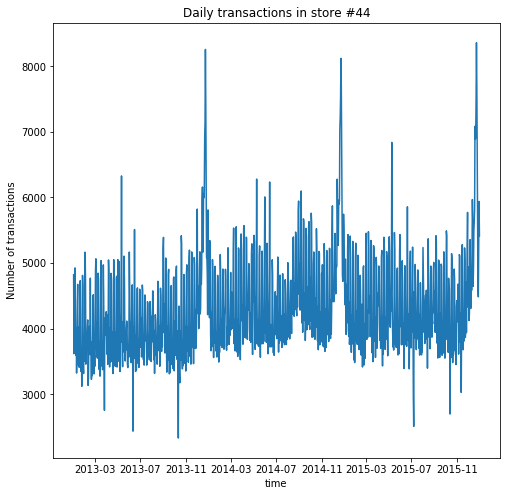

In [17]:
plt.figure(figsize=(8,8))
plt.title('Daily transactions in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

#### There are several peaks just before every year end. We can attribute this to the seasonality. The sales will surge during Year and and christmas.

In [18]:
def dickey_fuller_test(timeseries):
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [19]:
dickey_fuller_test(ts)

Test Statistic                   -4.013363
p-value                           0.001342
#Lags Used                       22.000000
Number of Observations Used    1066.000000
Critical Value (5%)              -2.864255
Critical Value (1%)              -3.436499
Critical Value (10%)             -2.568216
dtype: float64


#### The Time Series can be classified in to Stationary or Non Stationary. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
#### The Dickey-Fuller test has null-hypothesis that the time-series is non stationary. On our case the P value is less than 0.05. Hence we can reject the null hypothoesis and consider the time series as Stationary.

### ARIMA Model for Timeseries

ARIMA stands for AutoRegressive Integrated Moving Average.The ARIMA models have three parameters, corresponging to its AR, I and MA components:

1. The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable.
2. The number of differences (d): These are the number of non-seasonal differences.
3. The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation.

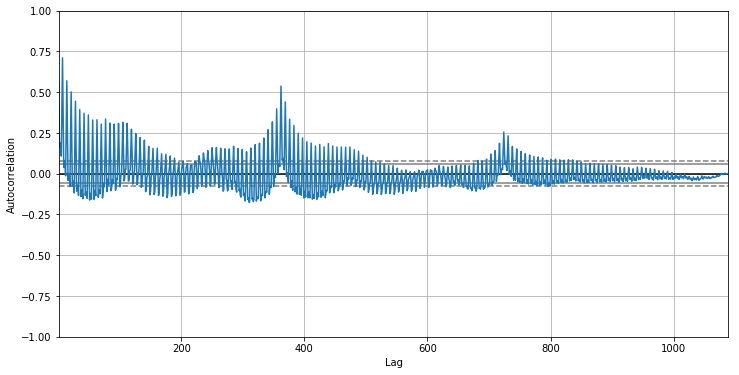

In [20]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);

#### The above plot shows that the peaks are attained once every 365 days. That sums up the seasonality.

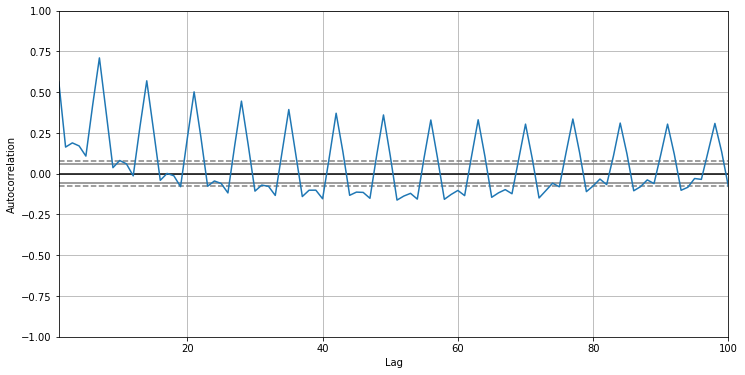

In [21]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=100);

#### If we limit this to 100 days, there are total of 14 spikes. Roughly once every 7 days. That also answers the trend that the Ecudorians follow weekly purchases mode.

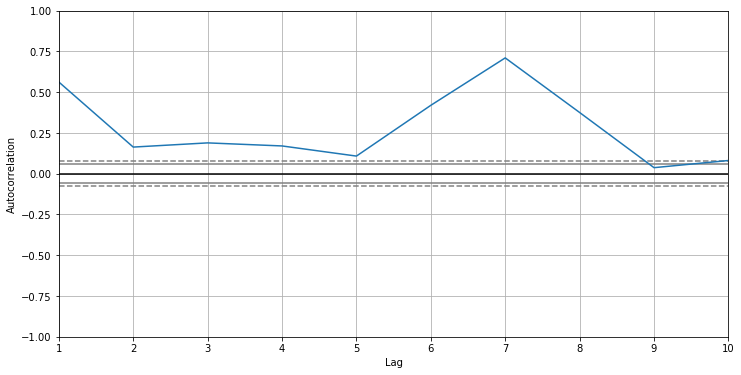

In [22]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=10);

#### This is further confirmed by the 10 days plot. where there is a spike at 7th day.

#### In the below code, a graph is ploted between the log time series and the moving average of  days.

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=8,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


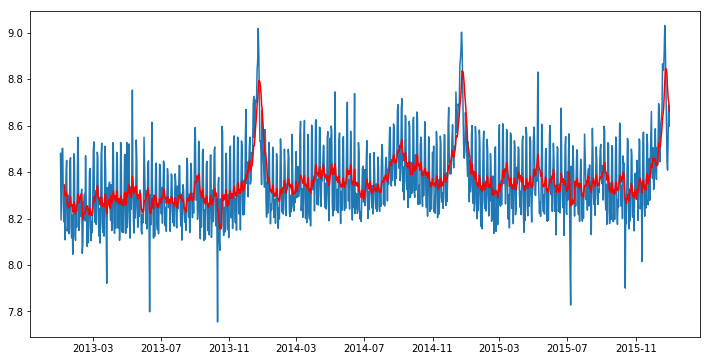

In [23]:
plt.figure(figsize=(12,6))
ts_log = np.log(ts)
moving_avg = pd.rolling_mean(ts_log,8)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [24]:
# The moving average difference between the original time series and the moving average of 8 days is calculated.
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(10)

date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09   -0.049045
2013-01-10   -0.189456
2013-01-11   -0.044809
Name: transactions, dtype: float64

In [25]:
# The DF Test is applied on the moving average time series after dropping the NAN data to check the stationality
ts_log_moving_avg_diff.dropna(inplace=True)
dickey_fuller_test(ts_log_moving_avg_diff)

Test Statistic                -7.937679e+00
p-value                        3.379080e-12
#Lags Used                     2.200000e+01
Number of Observations Used    1.059000e+03
Critical Value (5%)           -2.864273e+00
Critical Value (1%)           -3.436540e+00
Critical Value (10%)          -2.568225e+00
dtype: float64


#### This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

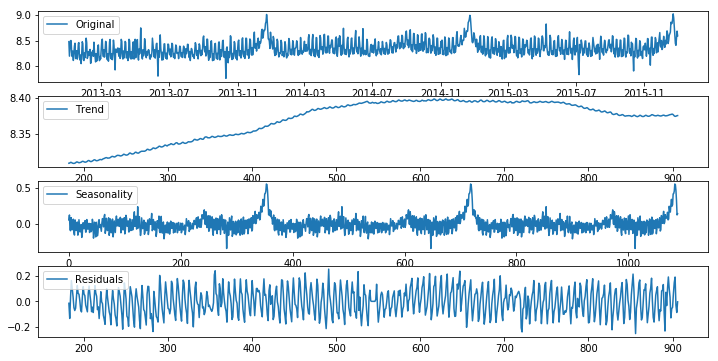

In [26]:
#### Let us plot the timeseries with decomposition data. I.e. Trend, Seasonal and Residual. The frequency is for 365 days.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

#### It is observed that over a year data, there is a definite trend in the sales. The seasonality is also well explained here as per our expection.

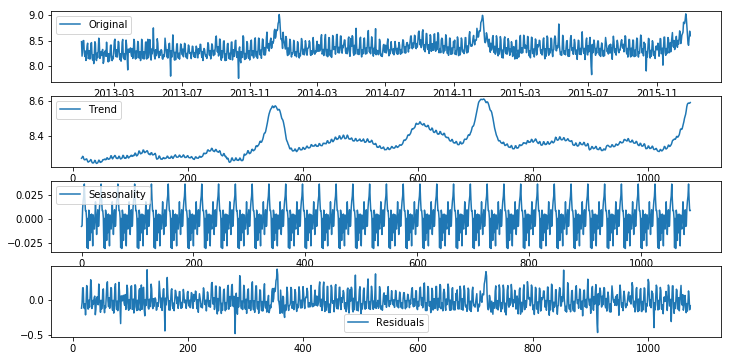

In [27]:
#### Let us plot the timeseries with decomposition data. I.e. Trend, Seasonal and Residual. The frequency is for 30 days.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

#### Over 30 days, if we observe correctly, there are six spikes approx between 200 days, so that also confirms our analysis.

In [28]:
### Applying ARIMA with the pdq values 5,0,5 and check the residuals
pdq=(5,0,5)
model = ARIMA(ts_log, order = pdq, freq='W')  
results_AR = model.fit(disp=False,method='css',maxiter=100) 
residuals = pd.DataFrame(results_AR.resid)
residuals.head()

,0
date,
2013-01-07,-0.381552
2013-01-08,-0.357352
2013-01-09,0.117899
2013-01-10,0.026263
2013-01-11,0.055091


,count,mean,std,min,25%,50%,75%,max
0,1084.0,-0.000005,0.08955,-0.477191,-0.047955,0.003344,0.047386,0.408671


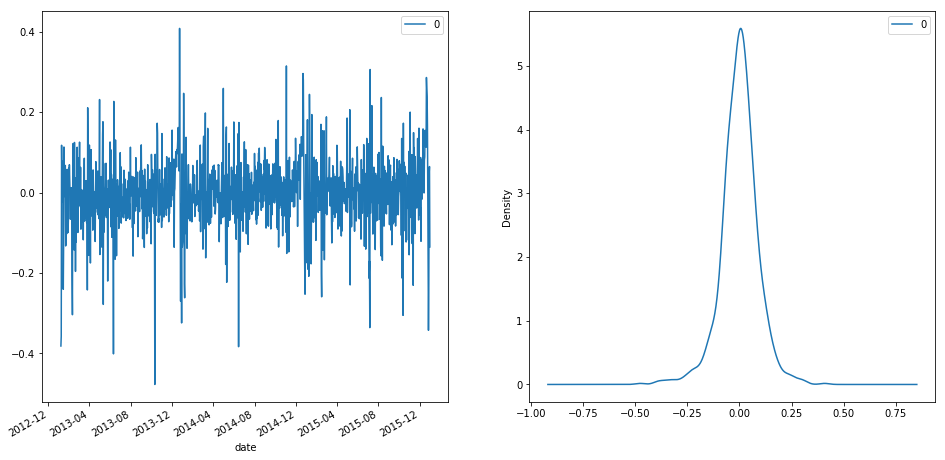

In [29]:
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
residuals.plot(ax=axes[0])
residuals.plot(kind='kde',ax=axes[1]);
residuals.describe().T

In [30]:
results_AR.fittedvalues.head()

date
2013-01-07    8.642820
2013-01-08    8.544095
2013-01-09    8.177649
2013-01-10    8.082361
2013-01-11    8.206693
dtype: float64

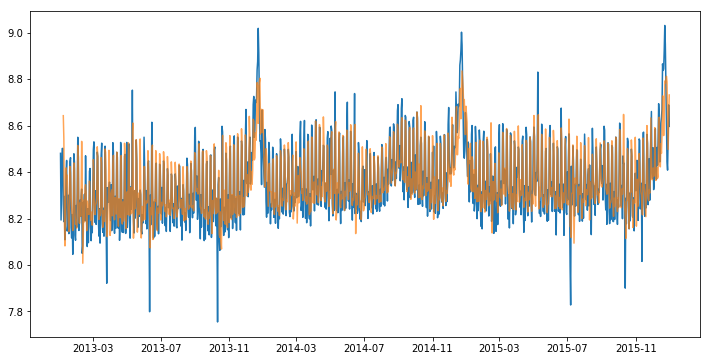

In [31]:
plt.figure(figsize=(12,6))
plt.subplot
plt.plot(ts_log);
plt.plot(results_AR.fittedvalues,alpha=.7);

#### The model does fit well. But we can see that some part of the outliers are fitted.

In [32]:
ts.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name=u'date', length=1089, freq=None)

In [33]:
####
from pyramid.arima import auto_arima
stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=365,
                           start_P=0, max_P=10, seasonal=True,
                           d=0, D=0,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) sea

In [34]:
stepwise_model.aic()

16601.362931948086

In [35]:
#forecast_len = 90
#size = int(len(ts_log)-forecast_len)
#train, test = ts_log[0:size], ts_log[size:len(ts_log)]
index = pd.date_range('2016-01-01', periods=31)
train  = ts_log
#columns = ['sales']
#test = pd.DataFrame(index=index, columns=columns)

In [36]:
fit_model = stepwise_model.fit(train)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1089
Model:               SARIMAX(3, 0, 5)   Log Likelihood                 786.895
Date:                Tue, 31 Jul 2018   AIC                          -1553.790
Time:                        07:34:01   BIC                          -1503.860
Sample:                             0   HQIC                         -1534.891
                               - 1089                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6126      0.974      2.683      0.007       0.704       4.521
ar.L1          0.4661      0.069      6.797      0.000       0.332       0.601
ar.L2         -0.5187      0.039    -13.195      0.000      -0.596      -0.442
ar.L3          0.7411      0.050     14.924      0.000       0.644       0.838
ma.L1          0.2501      0.086      2.913      0.004       0.082       0.418
ma.L2          0.5736      0.083      6.886      0.000       0.410       0.737
ma.L3         -0.2293      0.091     -2.525      0.012      -0.407      -0.051
ma.L4         -0.0513      0.064     -0.801      0.423      -0.177       0.074
ma.L5         -0.2242      0.057     -3.909      0.000      -0.337      -0.112
sigma2         0.0158      0.001     18.795      0.000       0.014       0.017
===================================================================================
Ljung-Box (Q):                     2543.88   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.99   Skew:                            -0.06
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
predict = np.exp(fit_model.predict(31))
predict = predict.astype(int)

In [38]:
future_forecast = pd.DataFrame(predict,index = index,columns=['Prediction'])
future_forecast.head(5)

,Prediction
2016-01-01,5165
2016-01-02,4974
2016-01-03,4856
2016-01-04,4678
2016-01-05,4766


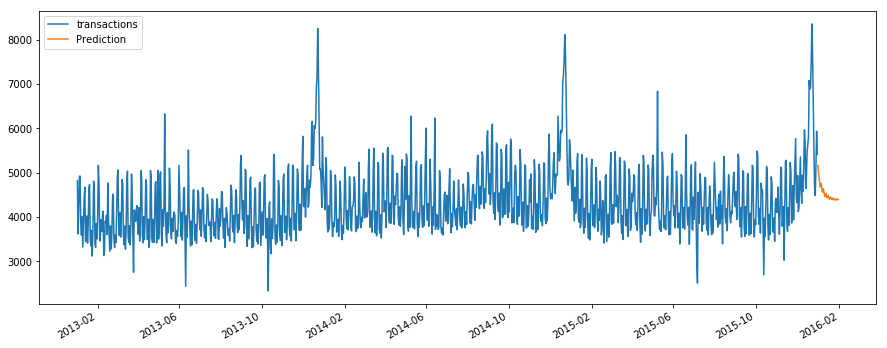

In [39]:
pd.concat([np.exp(train),future_forecast],axis=1).plot()

In [40]:
full_transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions.csv",header = True,inferSchema = True)
full_transaction_data.head()

Row(date=datetime.datetime(2013, 1, 1, 0, 0), store_nbr=25, transactions=770)

In [41]:
jan_2016_data =  full_transaction_data.filter(col('store_nbr') == 44).filter(year(col('date')) == 2016).filter(month(col('date')) == 1)
jan_2016_data_pd = jan_2016_data.toPandas()

In [42]:
jan_2016_data_pd.head()

,date,store_nbr,transactions
0,2016-01-02,44,4539
1,2016-01-05,44,4113
2,2016-01-06,44,4661
3,2016-01-07,44,3866
4,2016-01-08,44,4301


In [43]:
jan_2016_data_pd = jan_2016_data_pd.drop(['store_nbr'], axis=1)
jan_2016_data_pd.set_index('date')
jan_2016_data_pd.head()

,date,transactions
0,2016-01-02,4539
1,2016-01-05,4113
2,2016-01-06,4661
3,2016-01-07,3866
4,2016-01-08,4301


In [44]:
sum_trans =  full_transaction_data.filter(col('store_nbr') == 44).groupby(year('date'), month('date')).sum()
sum_trans.filter(col('year(date)') == 2016).filter(col('month(date)') == 1).show()

+----------+-----------+--------------+-----------------+
|year(date)|month(date)|sum(store_nbr)|sum(transactions)|
+----------+-----------+--------------+-----------------+
|      2016|          1|          1232|           120720|
+----------+-----------+--------------+-----------------+



In [45]:
sum(future_forecast['Prediction'])

140575

In [46]:
future_forecast.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31'],
              dtype='datetime64[ns]', freq='D')

In [47]:
jan_2016_data_pd['date'] = pd.to_datetime(jan_2016_data_pd['date'], format='%b %d, %Y')
jan_2016_data_pd.index = pd.to_datetime(jan_2016_data_pd['date'])
jan_2016_data_pd.columns = ['date', 'actuals']
jan_2016_data_pd.index

DatetimeIndex(['2016-01-02', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11',
               '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
               '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19',
               '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23',
               '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27',
               '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31'],
              dtype='datetime64[ns]', name=u'date', freq=None)

In [48]:
merged = future_forecast.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged.drop('date', axis = 1)
merged.head()

,Prediction,date,actuals
2016-01-02,4974,2016-01-02,4539
2016-01-05,4766,2016-01-05,4113
2016-01-06,4756,2016-01-06,4661
2016-01-07,4576,2016-01-07,3866
2016-01-08,4563,2016-01-08,4301


In [49]:
len(merged)

28

In [50]:
print("Sum of Predicted sales for Jan 2016 : " , sum(merged['Prediction']))
print("Sum of Actuals sales for Jan 2016 : " , sum(merged['actuals']))

('Sum of Predicted sales for Jan 2016 : ', 125876)
('Sum of Actuals sales for Jan 2016 : ', 120720)


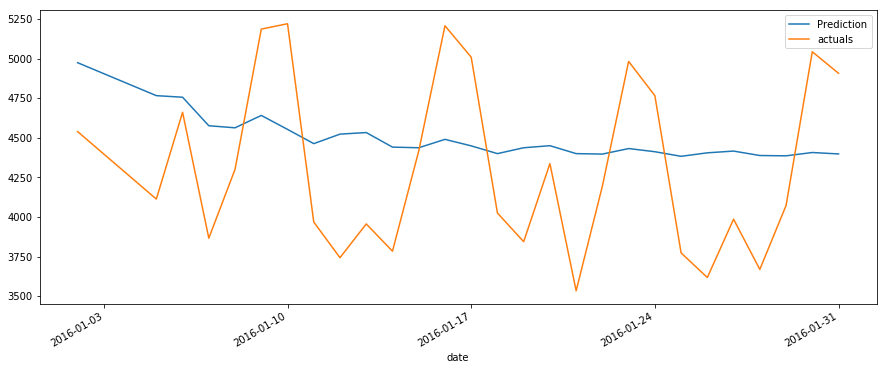

In [51]:
import seaborn as sns
merged.set_index('date').plot()

In [52]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(merged['actuals'], merged['Prediction']))

553.0619960081974

### Inference:
The total number of transactions reqported out of the model is 135006 and the actual number of transactions from the data for the month of Jan 2016 is 120720

## 2. Sulekha-Holtwinters implementation

In [54]:
#import package from sulekha_holtwinters.holtwinters
import sulekha_holtwinters

from sulekha_holtwinters import holtwinters as hw
hd = hw.holtwinters()
import sys

In [55]:
ts_2 = ts.reset_index()

In [56]:
# Load the dataset
ts_2 = sqlContext.createDataFrame(ts_2)

In [57]:
ts_2.show()

+-------------------+------------+
|               date|transactions|
+-------------------+------------+
|1357084800000000000|      4821.0|
|1357171200000000000|      3618.0|
|1357257600000000000|      4169.0|
|1357344000000000000|      4921.0|
|1357430400000000000|      4925.0|
|1357516800000000000|      3871.0|
|1357603200000000000|      3593.0|
|1357689600000000000|      4006.0|
|1357776000000000000|      3323.0|
|1357862400000000000|      3873.0|
|1357948800000000000|      4423.0|
|1358035200000000000|      4676.0|
|1358121600000000000|      3450.0|
|1358208000000000000|      3527.0|
|1358294400000000000|      4026.0|
|1358380800000000000|      3412.0|
|1358467200000000000|      3801.0|
|1358553600000000000|      4656.0|
|1358640000000000000|      4732.0|
|1358726400000000000|      3508.0|
+-------------------+------------+
only showing top 20 rows



In [58]:
ts_2.count()

1089

In [60]:
Observed, Predictions, Level, Trend, Seasonality = hd.holtwinters_additive(ts_2,0.865,0.01,0.865,365,31)

In [61]:
hd.Accuracy(Observed, Predictions)

99.81434094043071

In [62]:
hd.ABSError(Observed, Predictions)

8459.442590997267

In [63]:
hd.Error(Observed, Predictions)

-334.8200979315325

In [64]:
hd.MAPE(Observed, Predictions)

0.18565905956920556

In [65]:
hd.BestFit_Additive(ts_2, interval=865, denominator=1000,L = 24,n_predictions = 31)

(99.73786617356771, 0.865, 0.0, 0.865)

In [66]:
hd.RMSE(Observed, Predictions)

328.86136003245656

In [67]:
SeasonalIndices,Avgs,Subset = hd.initiate_seasonal_indices_additive(ts_2,24)

In [68]:
model1 = hd.holtwinters_additive(ts_2,0.865,0.01,0.865,365,31)
hd.CreateGraphs(model1)

In [69]:
len(Predictions) - ts_2.count() 

31

In [70]:
predict_HW = pd.DataFrame(Predictions[ts_2.count():], columns = ['Predict HW'] )

In [71]:
predict_HW = predict_HW.astype(int)

In [72]:
len(predict_HW)

31

In [73]:
predict_HW.index = future_forecast.index

In [74]:
predict_HW.head()

,Predict HW
2016-01-01,5774
2016-01-02,5356
2016-01-03,5690
2016-01-04,5239
2016-01-05,5255


In [75]:
merged_HW = predict_HW.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged_HW = merged_HW.drop('date', axis = 1)
merged_HW.head()

,Predict HW,actuals
2016-01-02,5356,4539
2016-01-05,5255,4113
2016-01-06,4820,4661
2016-01-07,5481,3866
2016-01-08,5048,4301


In [76]:
print("Sum of Predicted sales for Jan 2016 : " , sum(merged_HW['Predict HW']))
print("Sum of Actuals sales for Jan 2016 : " , sum(merged_HW['actuals']))

('Sum of Predicted sales for Jan 2016 : ', 131601)
('Sum of Actuals sales for Jan 2016 : ', 120720)


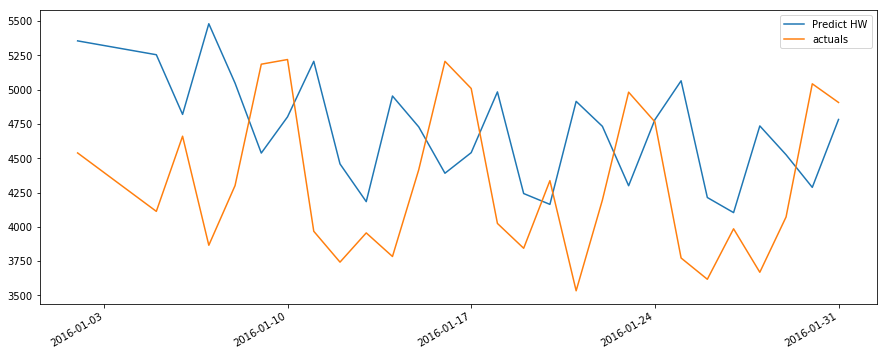

In [77]:
merged_HW.plot()